In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import matplotlib as mpl
from matplotlib.patches import Circle

import model.networks as networks
import model.vdm_model as vdm_model
import utils.utils as utils
import data.constants as constants

device="cuda:3" if torch.cuda.is_available() else "cpu"
print(device)

cuda:3


In [2]:
plt.style.use(['science', 'vibrant'])
mpl.rcParams['figure.dpi'] = 300
plt.rcParams.update({
    'axes.titlesize': 11,
    'legend.loc': 'upper right',
    'legend.fontsize': 6
    })

In [3]:
def load_model(dataset = 'Astrid',
        cropsize = 128,
        gamma_min = -13.3,
        gamma_max = 13.3,
        embedding_dim = 48,
        norm_groups = 8,
        use_fourier_features = False,
        add_attention = False,
        noise_schedule = 'learned_linear',
        n_blocks = 4
):
    vdm = vdm_model.LightVDM(
            score_model=networks.UNetVDM(
                gamma_min=gamma_min,
                gamma_max=gamma_max,
                embedding_dim=embedding_dim,
                norm_groups=norm_groups,
                n_blocks=n_blocks,
                add_attention=add_attention,
                use_fourier_features=use_fourier_features
            ),
            dataset=dataset,
            gamma_min=gamma_min,
            gamma_max=gamma_max,
            image_shape=(1,128,128,128),
            noise_schedule=noise_schedule,
            n_sampling_steps=1000
        )
    vdm = vdm.to(device=device)
    vdm = vdm.eval()
    ckpt = '/opt/data/private/wangjuntong/code/redshift/debiasing_redshift_0to1/e64e296441fa43d0a5e4cd0782de5fc8/checkpoints/epoch=513-step=3084-val_loss=1.003.ckpt'

    state_dict=torch.load(ckpt)["state_dict"]
    vdm.load_state_dict(state_dict)
    return vdm.eval()

In [4]:
dataset = 'Astrid'

In [5]:
# Load data
mass_mstar = np.load(f'Grids_Mcdm_{dataset}_CV_128_z=0.0.npy')
mass_cdm = np.load(f'Grids_Mcdm_{dataset}_CV_128_z=1.0.npy')
mass_mstar = np.log10(mass_mstar+1)
mass_cdm = np.log10(mass_cdm)

mean_input = constants.norms[dataset][0]
std_input = constants.norms[dataset][1]
mean_target = constants.norms[dataset][2]
std_target = constants.norms[dataset][3]

mass_mstar_normed = torch.Tensor((mass_mstar - mean_input) / std_input).unsqueeze(1).unsqueeze(1)
mass_cdm_normed = torch.Tensor((mass_cdm - mean_target) / std_target).unsqueeze(1).unsqueeze(1)
print("Mass mstar normed shape:", mass_mstar_normed.shape)
print("Mass cdm normed shape:", mass_cdm_normed.shape)

Mass mstar normed shape: torch.Size([27, 1, 1, 128, 128, 128])
Mass cdm normed shape: torch.Size([27, 1, 1, 128, 128, 128])


In [7]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
# Generate image fields
conditioning = mass_mstar_normed[0].to(device)
x = mass_cdm_normed[0].to(device)
vdm = load_model()
sample = vdm.draw_samples(
                conditioning=conditioning,
                batch_size=len(x),
                #n_sampling_steps=vdm.hparams.n_sampling_steps,
                n_sampling_steps=200
            )
sample = sample * std_target + mean_target
print("sample shape:", sample.shape)

sample shape: torch.Size([1, 1, 128, 128, 128])


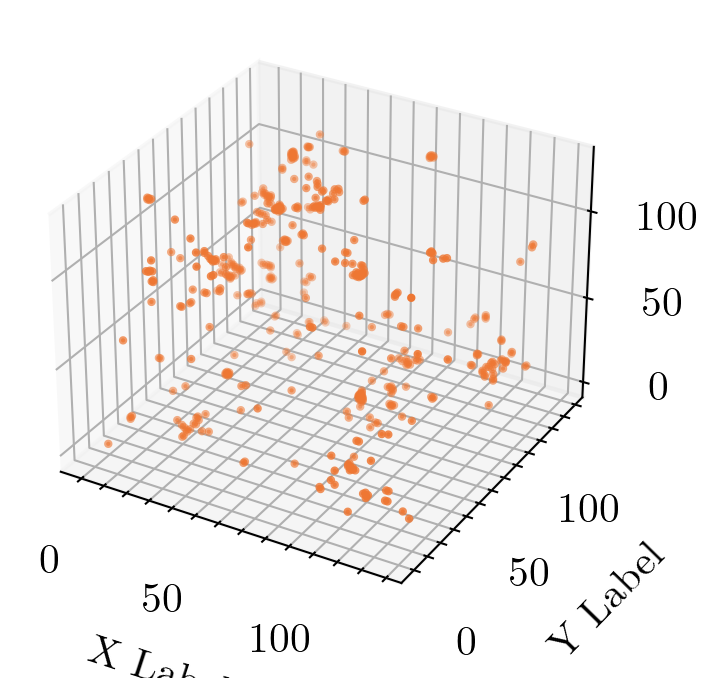

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming `sample` is your tensor with shape [1, 1, 128, 128, 128]
# and you've converted it to a numpy array for plotting
sample_numpy = sample[0][0].cpu().numpy()

# Just for demonstration, let's create a dummy 3D data
# Replace this with: sample_numpy = sample.cpu().numpy()
#sample_numpy = np.random.rand(128, 128, 128)

# Threshold to visualize high values, for example
threshold = 13

# Extracting the coordinates of points above the threshold
x, y, z = np.where(sample_numpy > threshold)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting
ax.scatter(x, y, z, s=1)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()


In [14]:
print(sample_numpy[0][0])

[10.361607  10.211002  10.0851965  9.991564   9.932797   9.7575245
  9.352974   9.459338   9.678413   9.761411   9.689507   9.729836
  9.511931   9.600589   9.965675   9.822358   9.717686   9.647944
  9.549931   9.946941  10.354288  10.661445  10.781823  10.535004
  9.948153   9.648925   9.806809  10.182784  10.340692  10.116546
 10.006155   9.889811   9.68397    9.706087   9.536741   9.733734
  9.653453   9.582362   9.672596   9.671112   9.537961   9.627073
  9.6863575  9.875921  10.019306   9.868385   9.729342   9.945201
 10.278469  10.4529295 10.378648  10.382659  10.198054  10.0474415
 10.086258  10.144414  10.020886   9.775561   9.509525   9.400235
  9.355736   9.319196   9.270217   9.34134    9.366378   9.711998
 10.21841   10.810701  10.607727  10.00399    9.764965   9.748545
 10.0486355 10.232109  10.490414  10.110318   9.725476   9.33586
  9.433135   9.678452   9.985992  10.0457325 10.043938   9.883312
  9.575597   9.536789   9.6665125  9.911288   9.759253   9.567713
  9.66088

In [9]:
colors = ['#935083', '#FB8B6F', '#FFBE62', '#D16580','#00C89E']

In [10]:
halos = {
    (50, 89,63) : 5,
    (50, 46,63) : 4,
    (8, 38,63) : 5,
    (60, 37,63) : 4,
    (18, 92,63) : 7,
}

In [11]:
X, Y ,Z= np.ogrid[:128, :128,:128]
true_masses = []
masks = []
for center, radius in halos.items():
    distance = np.sqrt((X-center[0])**2+(Y-center[1])**2+(Z-center[2])**2)
    cdm_mass = mass_cdm[0].squeeze()
    mask = distance <= radius
    masks.append(mask)
    masked = cdm_mass.copy()
    masked[~mask] = 0
    true_masses.append(np.sum(10 ** masked))

In [12]:
def generate_samples(vdm, conditioning, batch_size=1, n=80):

    star = conditioning[0]
    star_fields = star.expand(batch_size, star.shape[0], star.shape[1], star.shape[2],star.shape[3])

    maps = [] # n tensors of shape ([batch_size, 1, img_shape, img_shape])
    # draw n samples with the same conditioning
    for _ in range(n):
        sample = vdm.draw_samples(
            conditioning=star_fields,
            batch_size=batch_size,
            #n_sampling_steps=vdm.hparams.n_sampling_steps,
            n_sampling_steps=200
            )
        maps.append(sample)
        
    return maps

In [19]:
print(mass_mstar_normed.shape)

torch.Size([27, 1, 1, 128, 128, 128])


In [13]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [14]:
# Get total masses
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vdm = load_model(dataset=dataset)
generated_masses = []
generated_normed = torch.vstack(
    generate_samples(
        vdm,
        conditioning=mass_mstar_normed[0].to(device), 
        batch_size=1, 
        n=250,
    )
)
generated = generated_normed * std_target + mean_target
for mask in masks:
    generated_mass = []
    for sample in generated:
        masked = sample.squeeze().detach().clone()
        masked[~mask] = 0
        generated_mass.append(torch.sum(10**masked).item())
    generated_masses.append(np.array(generated_mass))

In [22]:
# 设定保存路径
generated_masses_path = 'mass_regions_generated_masses.npy'
generated_normed_path = 'mass_regions_generated_normed.pt'
generated_path = 'mass_regions_generated.pt'

# 使用torch.save保存PyTorch张量
torch.save(generated_normed, generated_normed_path)
torch.save(generated, generated_path)

# 使用numpy.save保存numpy数组
np.save(generated_masses_path, generated_masses)


In [23]:
generated_masses_path = 'mass_regions_generated_masses.npy'
generated_normed_path = 'mass_regions_generated_normed.pt'
generated_path = 'mass_regions_generated.pt'

# 使用torch.load加载PyTorch张量
generated_normed = torch.load(generated_normed_path)
generated = torch.load(generated_path)

# 使用numpy.load加载numpy数组
generated_masses = np.load(generated_masses_path)

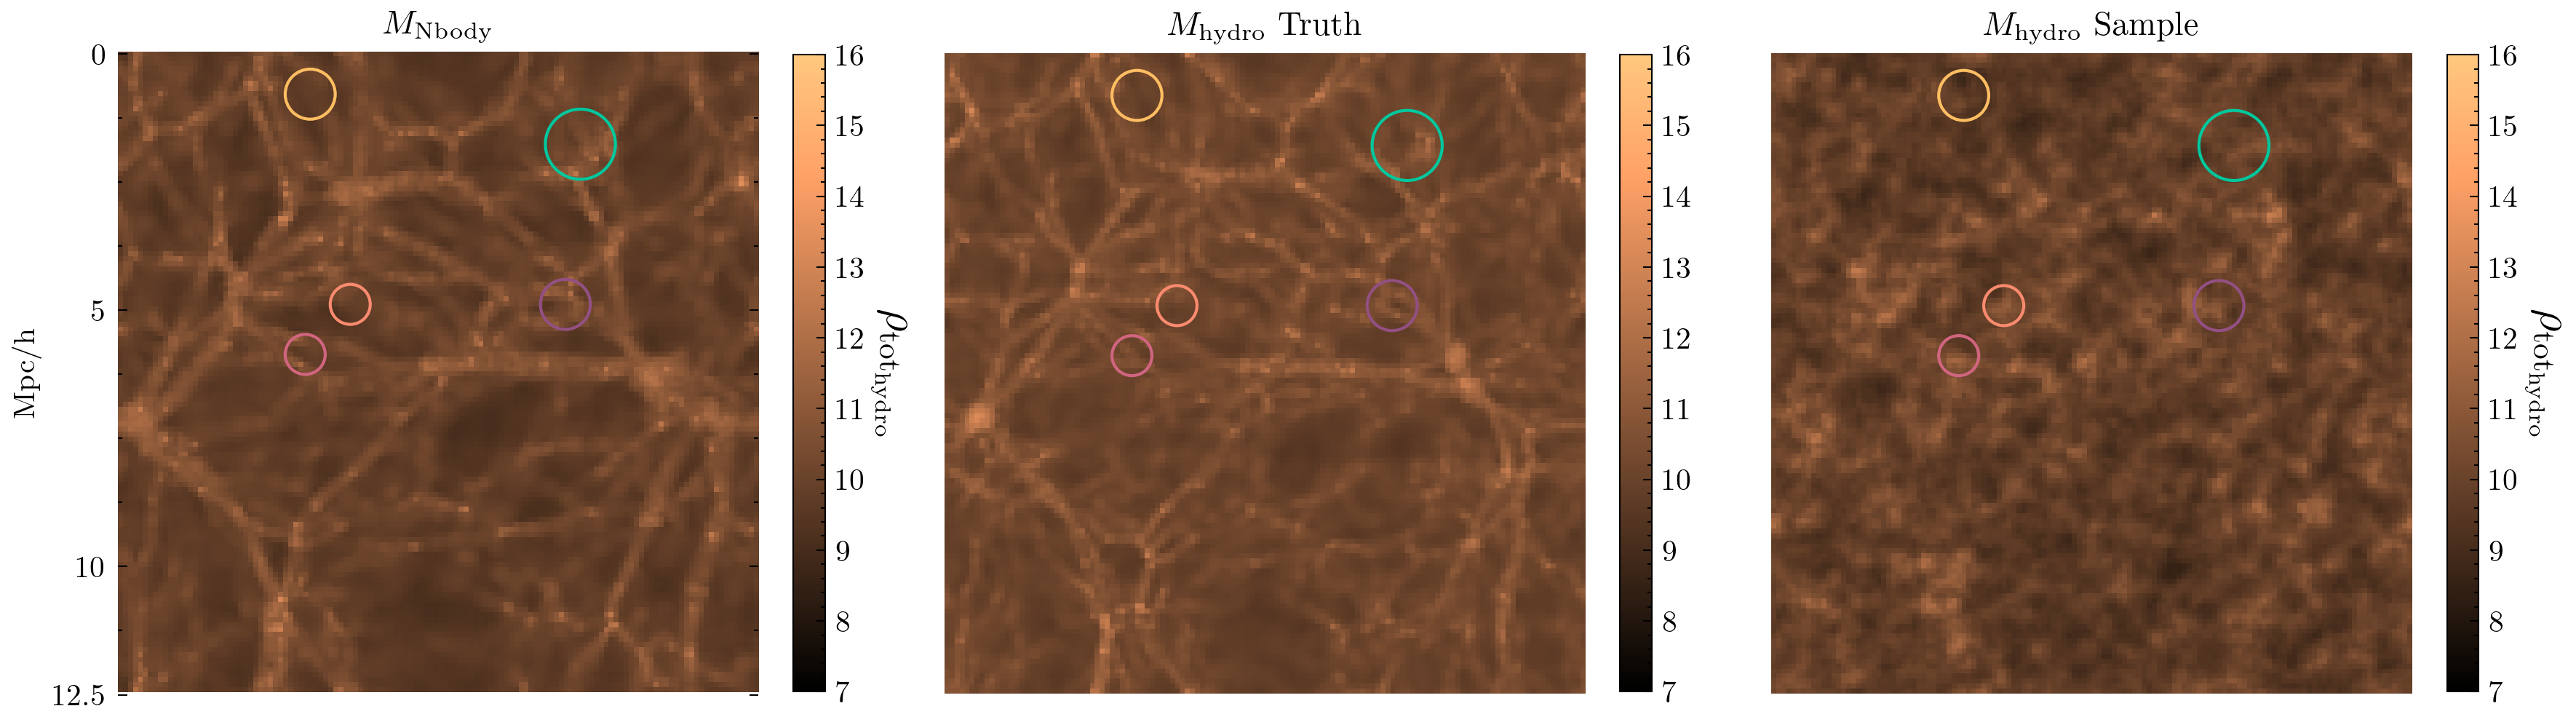

In [28]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import numpy as np
mass_mstar_selected = mass_mstar[0].squeeze()
# Select a middle slice from the 3D volume, here the 64th slice along the z-axis
slice_index = 63
fig, axes = plt.subplots(1,3, figsize=(12,4))

img = axes[0].imshow(mass_mstar[0, slice_index, :, :], cmap='copper',vmin=7,vmax=16)  # Adjusted for correct indexing
cbar = fig.colorbar(img, ax=axes[0], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"$\rho_{\mathrm{tot_{hydro}}}$", rotation=270, fontsize=15)

img = axes[1].imshow(mass_cdm[0, slice_index, :, :], cmap='copper',vmin=7,vmax=16)
fig.colorbar(img, ax=axes[1], fraction=0.045)

img = axes[2].imshow(generated[79, 0,slice_index, :, :].cpu(), cmap='copper',vmin=7,vmax=16)
cbar = fig.colorbar(img, ax=axes[2], fraction=0.045)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r'$\rho_{\mathrm{tot_{hydro}}}$', rotation=270, fontsize=15)

for i, (center, radius) in enumerate(halos.items()):
    axes[0].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i], 
             fill=False,
             lw=1))
    axes[1].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))
    axes[2].add_patch(Circle((center[1], center[0]), radius,
             edgecolor = colors[i],
             fill=False,
             lw=1))

axes[0].spines['top'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].set_xticks([])
axes[0].set_yticks([0., 51.2, 102.4, 128], labels=["0", "5", "10", "12.5"])
axes[0].set_ylabel("Mpc/h")        
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title(r"$M_{\mathrm{Nbody}}$")
axes[1].set_title(r"$M_{\mathrm{hydro}}$ Truth")
axes[2].set_title(r"$M_{\mathrm{hydro}}$ Sample") 
plt.tight_layout()

Text(0.5, 1.0, 'Probability distribution of the halo mass')

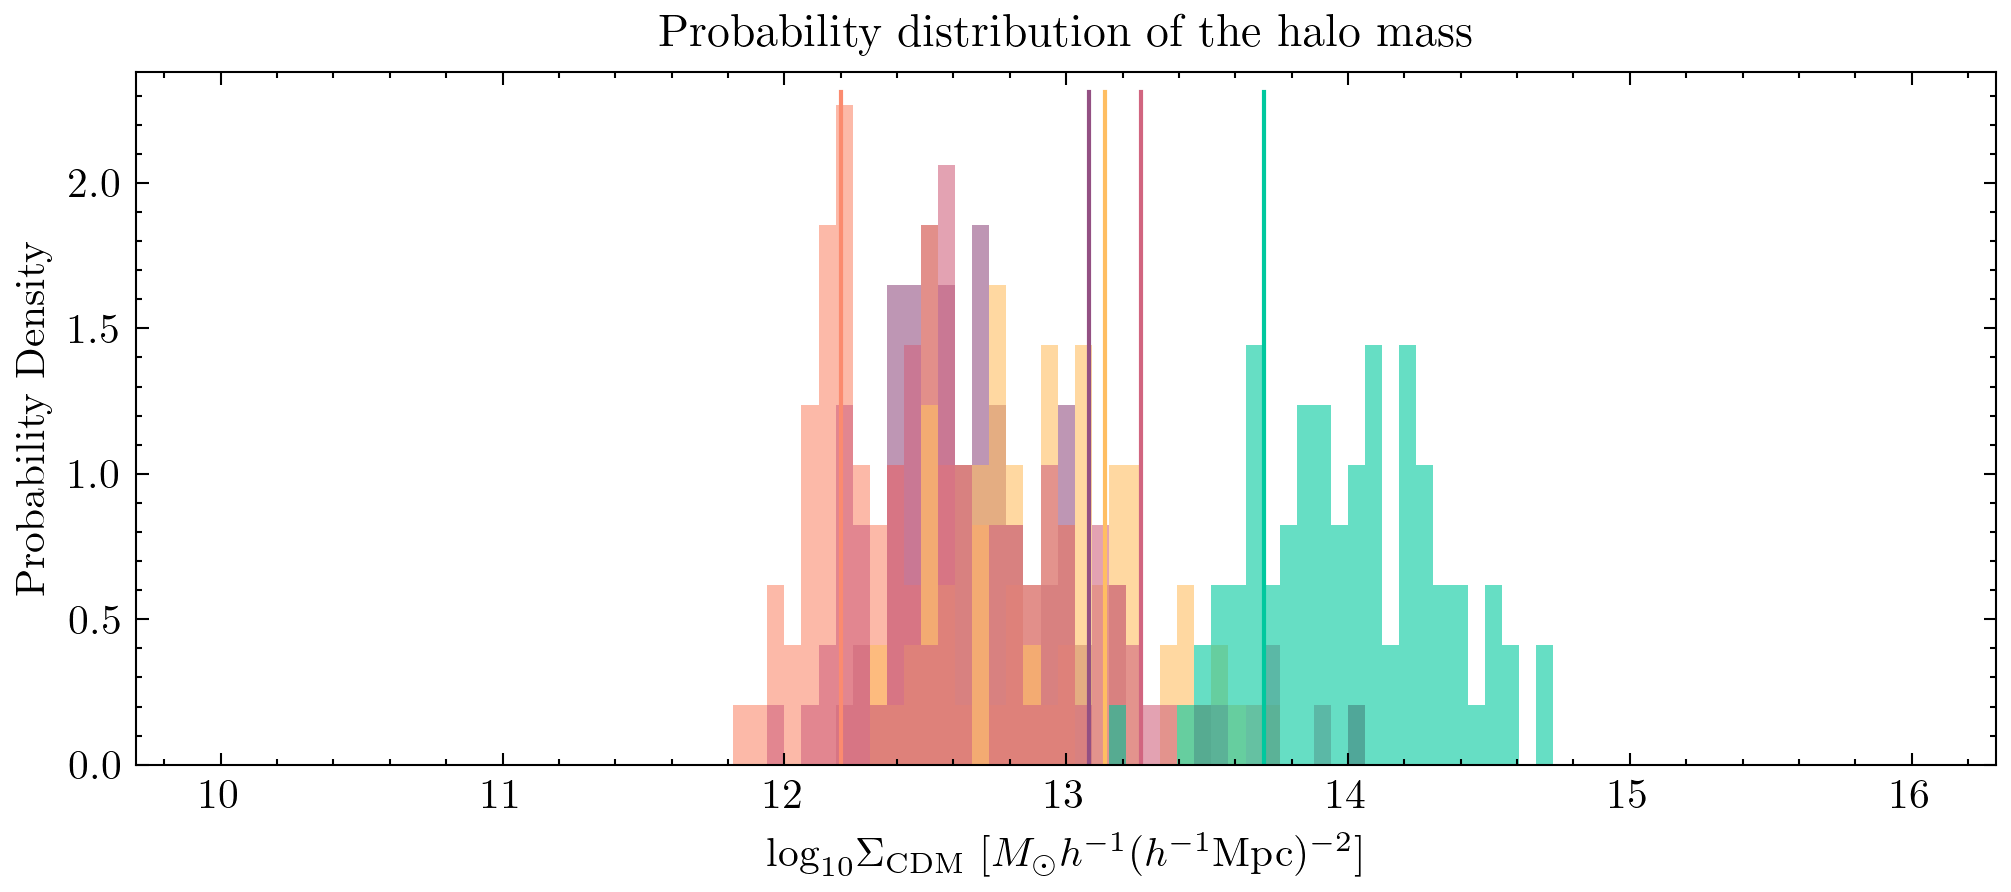

In [25]:
fig, ax = plt.subplots(figsize=(8,3))
n_bins = 25
mbin = np.linspace(10,16,100)
for i in range(len(generated_masses)):
  ax.hist(np.log10(generated_masses[i]), bins=mbin, color=colors[i], alpha=0.6, histtype='stepfilled', density=True,
            )
  ax.axvline(np.log10(true_masses[i]), 0, 0.97, color=colors[i])

ax.set_xlabel(r'$\mathrm{log}_{10} \Sigma_{\mathrm{CDM}}$ ' + '$[M_{\odot} h^{-1} ( h^{-1} \mathrm{Mpc})^{-2}]$')
ax.set_ylabel('Probability Density')
ax.set_title('Probability distribution of the halo mass')